In [1]:
import mne
import mne_bids
import os.path as op
from pathlib import Path
from glob import glob
import json
import matplotlib.pyplot as plt
import numpy as np
mne.set_log_level('ERROR')

In [ ]:
subject = 'sub-000'

In [3]:
in_file = glob(op.join('..', subject, 'eeg', subject + '*.set'))[0]
in_file

'../sub-002/eeg/sub-002_task-N400_eeg.set'

In [4]:
raw = mne.io.read_raw_eeglab(in_file, 
                             eog='auto', 
                             
                             preload=True)
raw.rename_channels({'FP1':'Fp1', 'FP2':'Fp2'})
raw.set_montage('standard_1020')
raw = mne.set_bipolar_reference(raw, 
                                ['HEOG_left', 'VEOG_lower'], 
                                ['HEOG_right', 'Fp1'],
                                ['HEOG', 'VEOG']
                                )
raw

<RawEEGLAB | sub-002_task-N400_eeg.fdt, 31 x 510976 (499.0 s), ~120.9 MB, data loaded>

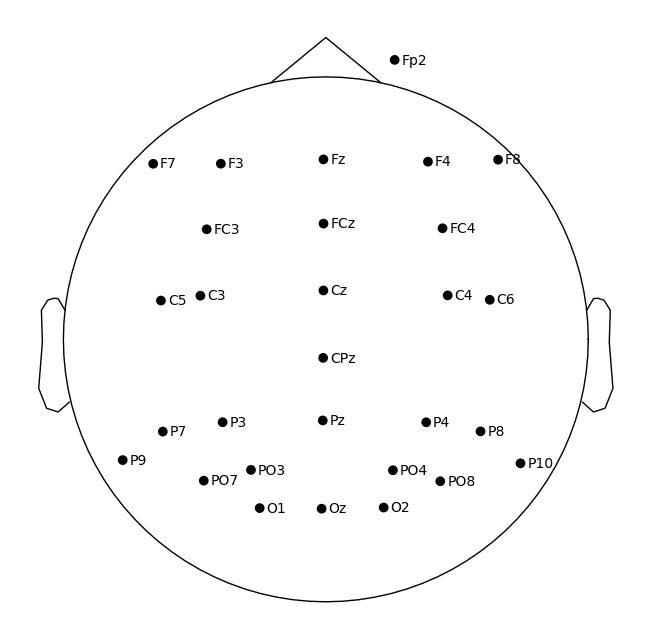

In [5]:
raw.plot_sensors(show_names=True);

/Users/aaron/miniforge3/envs/ncil/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


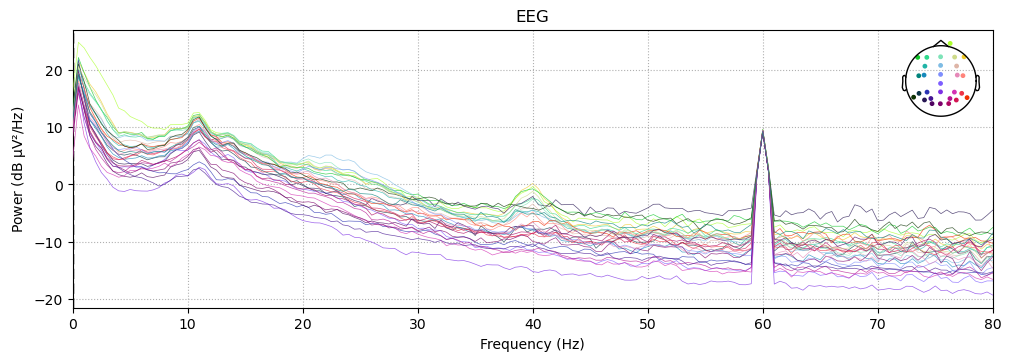

In [6]:
raw.compute_psd(fmax=80).plot()
plt.show()

In [7]:
raw.filter(0.1, 40)

<RawEEGLAB | sub-002_task-N400_eeg.fdt, 31 x 510976 (499.0 s), ~120.9 MB, data loaded>

/Users/aaron/miniforge3/envs/ncil/lib/python3.12/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


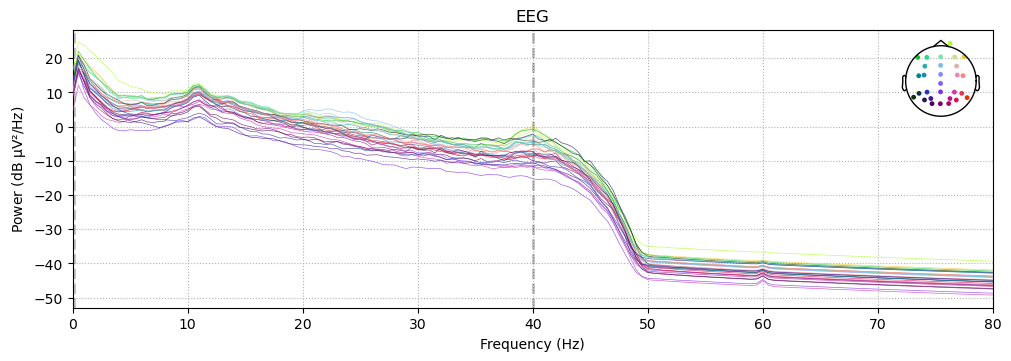

In [8]:
raw.compute_psd(fmax=80).plot()
plt.show()

In [9]:
events, event_id = mne.events_from_annotations(raw)

event_id_map = {'111': 'prime/related/list1',
                '112': 'prime/related/list2',
                '121': 'prime/unrelated/list1',
                '122': 'prime/unrelated/list2',
                '211': 'target/related/list1',
                '212': 'target/related/list2',
                '221': 'target/unrelated/list1',
                '222': 'target/unrelated/list2',
                '201': 'resp/correct/list1',
                '202': 'resp/incorrect/list2'
                }

# map values of event_id_map to keys of event_id and save as event_id_new
event_id_new = {event_id_map[key]: value for key, value in event_id.items()}

event_id_new


{'prime/related/list1': 1,
 'prime/related/list2': 2,
 'prime/unrelated/list1': 3,
 'prime/unrelated/list2': 4,
 'resp/correct/list1': 5,
 'resp/incorrect/list2': 6,
 'target/related/list1': 7,
 'target/related/list2': 8,
 'target/unrelated/list1': 9,
 'target/unrelated/list2': 10}

In [10]:
tmin = -0.100
tmax =  1.000
epochs_ica = mne.Epochs(raw.copy().filter(1, 30), 
                        events, event_id_new, 
                        tmin=tmin, tmax=tmax, 
                        baseline=(None, 0), 
                        preload=True)

In [11]:
epochs_ica

<Epochs | 362 events (all good), -0.1 – 1 s (baseline -0.1 – 0 s), ~96.5 MB, data loaded,
 'prime/related/list1': 30
 'prime/related/list2': 30
 'prime/unrelated/list1': 30
 'prime/unrelated/list2': 30
 'resp/correct/list1': 109
 'resp/incorrect/list2': 13
 'target/related/list1': 30
 'target/related/list2': 30
 'target/unrelated/list1': 30
 'target/unrelated/list2': 30>

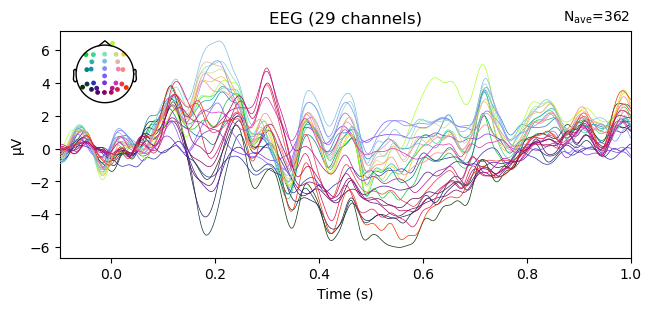

In [12]:
epochs_ica.average().plot()
plt.show()

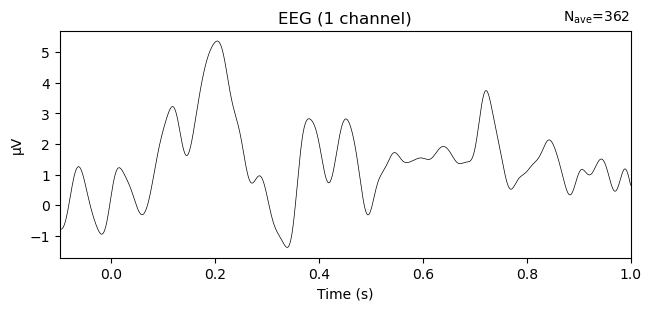

In [13]:
epochs_ica.average().plot(picks=['Cz'])
plt.show()

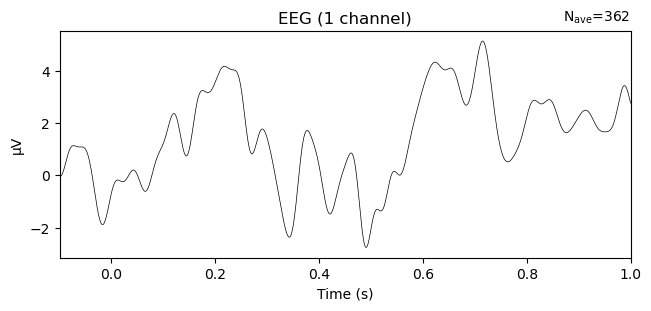

In [14]:
epochs_ica.average().plot(picks=['Fp2'])
plt.show()

In [15]:
ica = mne.preprocessing.ICA(n_components=.975, 
                             random_state=42, 
                             max_iter='auto'
                             )
ica.fit(epochs_ica,
        decim=3, 
        picks=['eeg']
        )

Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,24 iterations on epochs (136112 samples)
ICA components,12
Available PCA components,29
Channel types,eeg
ICA components marked for exclusion,—


In [ ]:
ica.exclude = []
num_excl = 0
z_thresh = 4
z_step = .25

while num_excl < 1 and z_thresh > 0:
    eog_indices, eog_scores = ica.find_bads_eog(epochs_ica, threshold=z_thresh)
    num_excl = len(eog_indices)
    z_thresh -= z_step # won't impact things if num_excl is ≥ n_max_eog 

ica.exclude = eog_indices
z_thresh_final = round(z_thresh + z_step, 2)
print(num_excl, 'components excluded with z_thresh =', z_thresh_final)

2 components excluded with z_thresh = 3.0


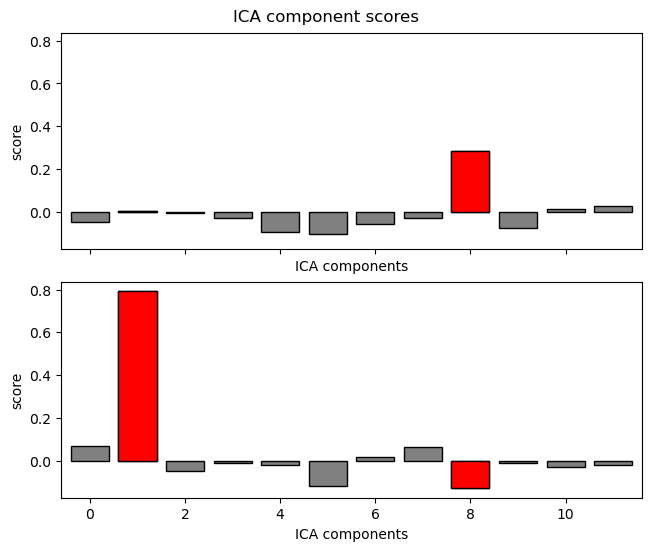

In [17]:
mne.viz.plot_eog_scores = ica.plot_scores(eog_scores)

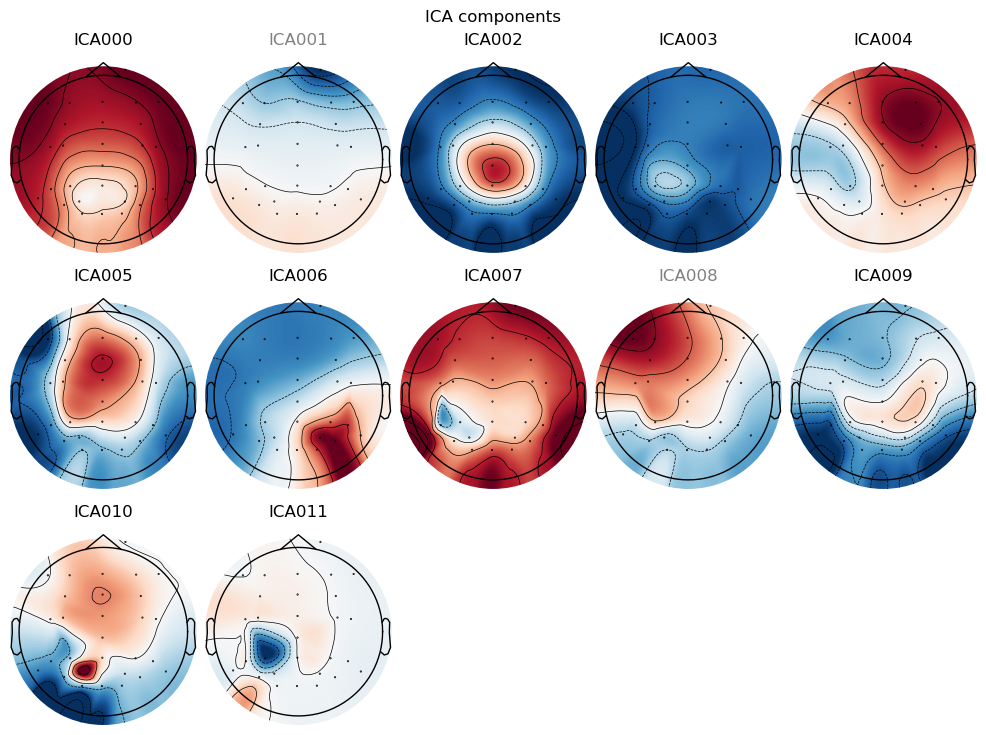

In [18]:
ica.plot_components()
plt.show()

In [19]:
epochs = mne.Epochs(raw,
                    events, event_id_new, 
                    tmin=tmin, tmax=tmax, 
                    baseline=(None, 0), 
                    preload=True)

ica.apply(epochs)


<Epochs | 362 events (all good), -0.1 – 1 s (baseline -0.1 – 0 s), ~96.5 MB, data loaded,
 'prime/related/list1': 30
 'prime/related/list2': 30
 'prime/unrelated/list1': 30
 'prime/unrelated/list2': 30
 'resp/correct/list1': 109
 'resp/incorrect/list2': 13
 'target/related/list1': 30
 'target/related/list2': 30
 'target/unrelated/list1': 30
 'target/unrelated/list2': 30>

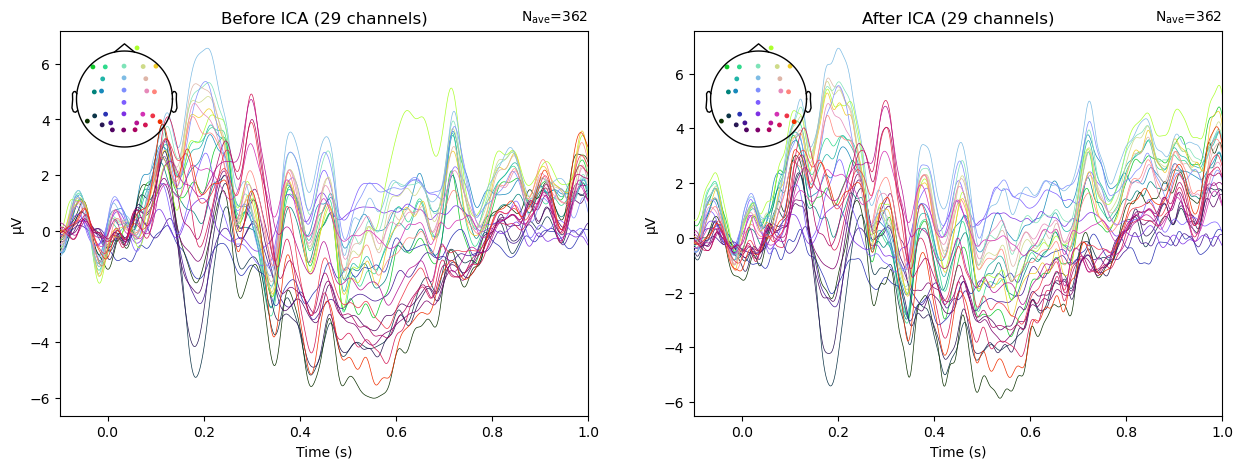

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
epochs_ica.average().plot(axes=axs[0], titles='Before ICA', show=False)
epochs.average().plot(axes=axs[1], titles='After ICA', show=True)
plt.show()

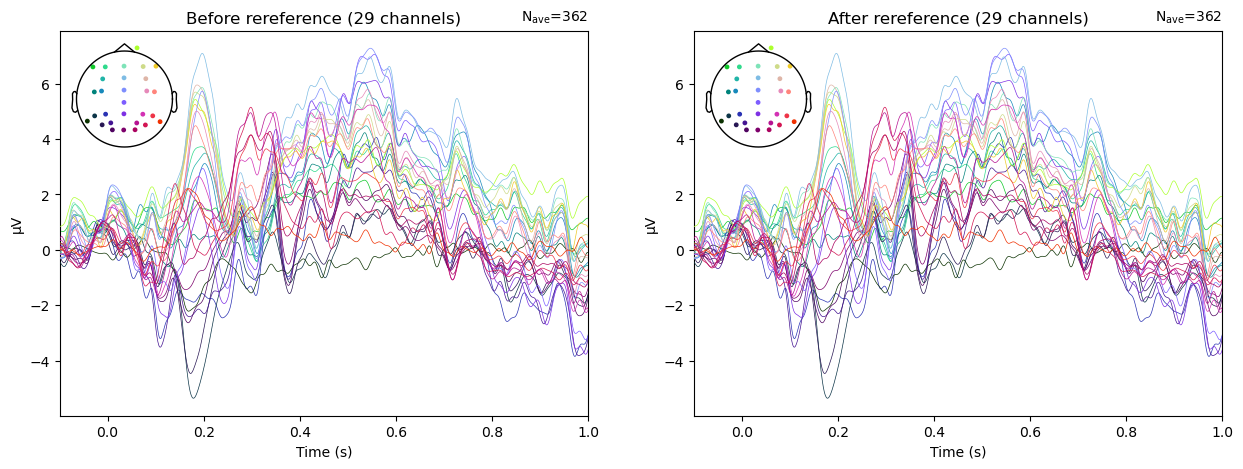

In [21]:
epochs_rr = epochs.set_eeg_reference(['P9', 'P10'])

derivatives_path = op.join('..', 'derivatives', subject)
if Path(derivatives_path).exists() == False:
    Path(derivatives_path).mkdir(parents=True)
epochs_rr.save(op.join(derivatives_path, subject + '-epo.fif'), overwrite=True)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
epochs.average().plot(axes=axs[0], titles='Before rereference', show=False)
epochs_rr.average().plot(axes=axs[1], titles='After rereference', show=True)
plt.show()

In [22]:
cond_of_interest = ['prime/related', 'prime/unrelated', 'target/related', 'target/unrelated']
evoked = {}
for condition in cond_of_interest:
    evoked[condition] = epochs_rr[condition].average()

In [23]:
evoked

{'prime/related': <Evoked | '0.50 × prime/related/list1 + 0.50 × prime/related/list2' (average, N=60), -0.099609 – 1 s, baseline -0.0996094 – 0 s, 29 ch, ~294 kB>,
 'prime/unrelated': <Evoked | '0.50 × prime/unrelated/list1 + 0.50 × prime/unrelated/list2' (average, N=60), -0.099609 – 1 s, baseline -0.0996094 – 0 s, 29 ch, ~294 kB>,
 'target/related': <Evoked | '0.50 × target/related/list1 + 0.50 × target/related/list2' (average, N=60), -0.099609 – 1 s, baseline -0.0996094 – 0 s, 29 ch, ~294 kB>,
 'target/unrelated': <Evoked | '0.50 × target/unrelated/list1 + 0.50 × target/unrelated/list2' (average, N=60), -0.099609 – 1 s, baseline -0.0996094 – 0 s, 29 ch, ~294 kB>}

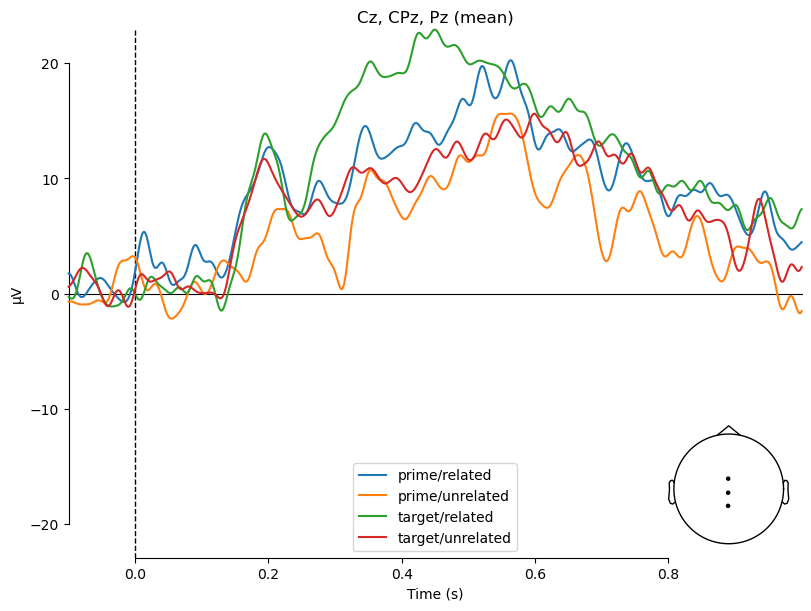

In [24]:
roi = ['Cz', 'CPz', 'Pz']
mne.viz.plot_compare_evokeds({c:evoked[c] for c in cond_of_interest},
                              picks=roi, combine='mean',
                              show_sensors='lower right', legend='lower center', 
                              ci=False,
                            );

In [25]:
contrasts = {'related': ['prime/related', 'target/related'],
             'unrelated': ['prime/unrelated', 'target/unrelated'],
             'mismatch': ['target/unrelated', 'target/related']
             }

evoked_diff = {}
for contrast, conditions in contrasts.items():
  evoked_diff[contrast] = [mne.combine_evoked([evoked[conditions[0]], evoked[conditions[1]]],
                                              weights=[1, -1])

                            ]
  

In [26]:
evoked_diff

{'related': [<Evoked | '(0.50 × prime/related/list1 + 0.50 × prime/related/list2) - (0.50 × target/related/list1 + 0.50 × target/related/list2)' (average, N=30.0), -0.099609 – 1 s, baseline -0.0996094 – 0 s, 29 ch, ~294 kB>],
 'unrelated': [<Evoked | '(0.50 × prime/unrelated/list1 + 0.50 × prime/unrelated/list2) - (0.50 × target/unrelated/list1 + 0.50 × target/unrelated/list2)' (average, N=30.0), -0.099609 – 1 s, baseline -0.0996094 – 0 s, 29 ch, ~294 kB>],
 'mismatch': [<Evoked | '(0.50 × target/unrelated/list1 + 0.50 × target/unrelated/list2) - (0.50 × target/related/list1 + 0.50 × target/related/list2)' (average, N=30.0), -0.099609 – 1 s, baseline -0.0996094 – 0 s, 29 ch, ~294 kB>]}

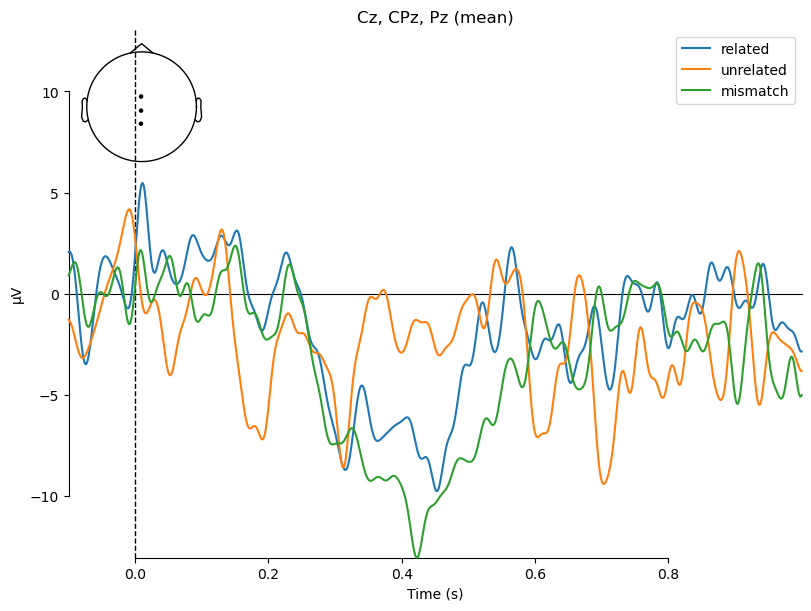

In [27]:
roi = ['Cz', 'CPz', 'Pz']
mne.viz.plot_compare_evokeds(evoked_diff, 
                             picks=roi, 
                             show_sensors='upper left', 
                             legend='upper right',
                             combine='mean',
                            #  ylim = {'eeg': (-3, 3)}
                             )
                             
plt.show()


 related


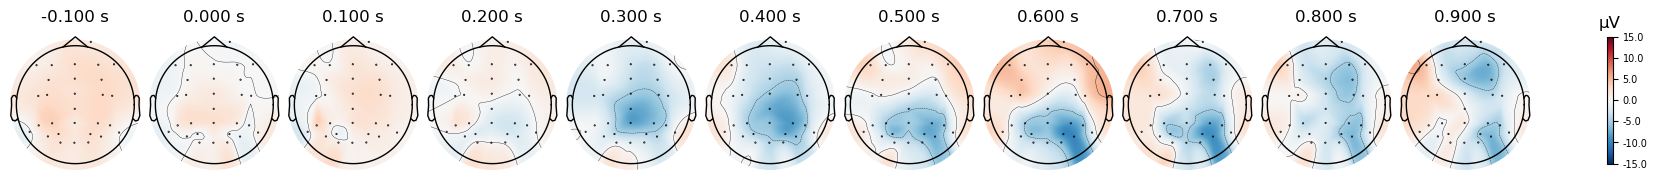


 unrelated


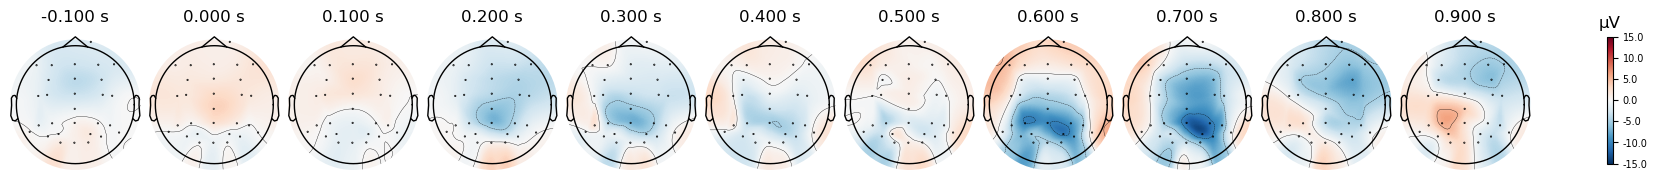


 mismatch


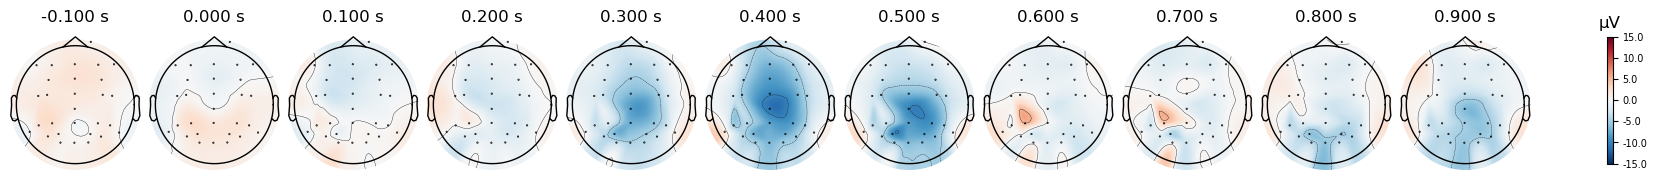

In [28]:
times = np.arange(tmin, tmax, .100)
uv_range = 15

for contrast in contrasts:
  print('\n', contrast)
  evoked_diff[contrast][0].plot_topomap(times, 
                                       ch_type='eeg', 
                                       vlim=[-uv_range, uv_range], 
                                       )